In [2]:
import os
import pickle
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(".."))  # Ensure it points to your project root

from van_code.nn import NeuralVANMultilevel_block_wise
from van_code.ising import ising_energy,analytical_solution,local_ising_energy
from van_code.montecarlo import *
from van_code.utils import *
from van_code.obs import Obs
from unzip import file_exists_or_unzip


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    default_dtype_torch=torch.float32
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = torch.device("cpu")
print(f'You are using device={device}.')

You are using device=mps.


-------------
-------------
# Model and parameters
Our multilevel architecture uses different blocks of Autoregressive neural networks which are based on the VAN architecture by [Wu et al. (2019)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.080602).

In [4]:
# This cell defines important parameters for the simulation

Lc=2 # defines the coarser lattice
beta=0.44 # defines the beta value (inverse of the temperature)

# VAN parameters
net_depth = 3
net_width= 16
half_kernel_size =6

# Conditional VAN parameters
# The i-th element of the list correspond to the parameters associated to the i-th block in the multilevel

hidden_size=[[32]] * 10 # Hidden size of each CondVAN
kernel_size=[[5,3]] * 10  # Kernel of CondVAN

#Elia: @Kim questo mi sa che e' da cambiare sistematicamente in "nblocks" 
nlevels = 2 # Defines the number of blocks (upsamling step) in the multilevel. Every block doubles the lattice. Example: if the coarser is 2x2 after 3 levels we have 16x16
hb_last = True # Whether to use heatbath to sample unbiased configuration from the last ARNN

In [5]:
van_hyp={
    'net_depth':net_depth,
    'net_width': net_width,
    'half_kernel_size':half_kernel_size,
    'bias':False,'z2':False,
    'res_block':True,
    'x_hat_clip':False,
    'final_conv':True,
    'epsilon':1.e-8,
    'device':device
}

block_net_hyp={
    'hidden_size':hidden_size,
    'kernel_size':kernel_size,
    'epsilon':1e-7,
    'level':0,
    'device':device
}

In [33]:
# Building the model

model = NeuralVANMultilevel_block_wise(
    Lc,
    van_hyp,
    block_net_hyp,
    nlevels,
    hb_last,
    ising_energy,
    local_ising_energy,
    beta,
    device
)
Lf = model.Lf
#print(model)

print(f'\n\n===============================================================================================================\n')
print(f'Starting from coarser lattice of shape {Lc}x{Lc} and sample finer lattices {model.Lf}x{model.Lf} using {nlevels} multilevel steps.')
print(f'\n\n===============================================================================================================\n')




Starting from coarser lattice of shape 2x2 and sample finer lattices 8x8 using 2 multilevel steps.





In [13]:
# Define default parameters for optimizer and scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.92, patience=1000, min_lr=1e-07)

# Define additional training parameters. Arbitrary values can be chosen
# the values chosen below are optimized for the purpose of this demo.

bs = 16
nepochs = 500
print_freq = 10
lr = 0.001

In [14]:
# Choose main path to store model and logs
main_path=''+'../data/'

# Creates model identifier with corresponding params
# '/Lf'+'_beta'+'_nblocks'+'_PCNNdepth'+'_width'+'_half_ker'+'_CCNNhs'+'_ks'

model_id = f'{str(model.Lf)}_{str(beta)}_{str(nlevels)}_{str(net_depth)}_{str(net_width)}_{str(half_kernel_size)}_{str(hidden_size[0][0])}_{str(kernel_size[0])}'

lc_path = main_path + 'training/' + model_id
h_path = lc_path + '_history.log' # Path to Training history

## Dict of paths to store different results

res_paths = {
    'weights': main_path+ 'model/'+ model_id +'.pth', # models' weights
    'sim' : main_path + 'results/' + model_id + '_measures.log',  # Simulations logging
    'sim_md' : main_path + 'results/' + model_id + '_measures_modedrop.log',  # Simulations mode dropping
    'cluster' : main_path + 'results/' + model_id + '_measuresCluster.log',  # Simulations
    'dict_hist' : lc_path + '_historyDict.pkl',  # dictionary learning curve
    'mh' : main_path+'results/'+ model_id +'_measuresIMH.log' # neural MCMC sampling results
}


-------------
-------------
# Training

### Let's train a RiGCS model by recursevily training coarser models:

In [15]:
res_paths['weights']= 'pd.pth'

In [16]:
ESS=[]
for i in range(0,nlevels+1):
    if i !=0:
        saved_state_dict = torch.load(res_paths['weights'])
        model.load_state_dict(saved_state_dict, strict=True)
    model = NeuralVANMultilevel_block_wise(
        Lc,
        van_hyp,
        block_net_hyp,
        i,
        hb_last,
        ising_energy,
        local_ising_energy,
        beta,
        device
        )
    
    history=model.train(500, bs, lr, print_freq, h_path, flex_kernel=True, on_file=True)

    torch.save(model.state_dict(),res_paths['weights'])
    ESS+=history['ESS']

/Users/kimnicoli/Projects/multilevelTest/van_code/nn.py:713: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # this function will be deprecated. When this happens use function below.
/Users/kimnicoli/Projects/multilevelTest/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Training VAN layers...
step: 10, loss: -0.05170673131942749, w_mean: -2.3338639736175537, w_var: 4.638050556182861, ess: 0.168049156665802, free_en: -4.289906024932861, log_prob: -2.7738637924194336
step: 20, loss: -0.05901855230331421, w_mean: -3.624880075454712, w_var: 2.3489487171173096, ess: 0.29934269189834595, free_en: -4.902406692504883, log_prob: -2.744880199432373
step: 30, loss: -0.12782669067382812, w_mean: -2.775432825088501, w_var: 3.0229082107543945, ess: 0.18218475580215454, free_en: -4.236964225769043, log_prob: -2.775432825088501
step: 40, loss: -0.13017049431800842, w_mean: -2.8197357654571533, w_var: 1.3512506484985352, ess: 0.1700136810541153, free_en: -3.6168198585510254, log_prob: -2.8197360038757324
step: 50, loss: -0.5987681746482849, w_mean: -2.411957025527954, w_var: 3.317906379699707, ess: 0.21466876566410065, free_en: -3.7939085960388184, log_prob: -2.851957082748413
step: 60, loss: -0.593107283115387, w_mean: -3.7598235607147217, w_var: 1.2537487745285034, 

step: 470, loss: -0.012341734953224659, w_mean: -4.35828971862793, w_var: 0.0011177086271345615, ess: 0.9990124702453613, free_en: -4.358802795410156, log_prob: -1.2782894372940063
step: 480, loss: -0.013423032127320766, w_mean: -4.351743698120117, w_var: 0.0011274368735030293, ess: 0.9989772439002991, free_en: -4.352266311645508, log_prob: -1.711743712425232
step: 490, loss: -0.006073173135519028, w_mean: -4.359334945678711, w_var: 0.0026217070408165455, ess: 0.9975073337554932, free_en: -4.360569477081299, log_prob: -1.4993352890014648
step: 500, loss: -0.05056461691856384, w_mean: -4.365924835205078, w_var: 0.0047049266286194324, ess: 0.9964491128921509, free_en: -4.367978096008301, log_prob: -1.065925121307373
Total time taken : 6.704712867736816
Training Started at level_ 1


/Users/kimnicoli/Projects/multilevelTest/van_code/nn.py:774: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): #this function will be deprecated. If this happens use function below.
/Users/kimnicoli/Projects/multilevelTest/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


step: 10, loss: -1.7831124067306519, w_mean: -13.797053337097168, w_var: 1.8983842134475708, ess: 0.2013511210680008, free_en: -14.928766250610352, log_prob: -8.737052917480469
step: 20, loss: -2.98883056640625, w_mean: -14.165549278259277, w_var: 2.75931978225708, ess: 0.14229322969913483, free_en: -15.894775390625, log_prob: -8.885549545288086
step: 30, loss: -1.3612111806869507, w_mean: -14.060089111328125, w_var: 1.6249300241470337, ess: 0.30047962069511414, free_en: -14.951824188232422, log_prob: -8.89008903503418
step: 40, loss: -1.6262030601501465, w_mean: -14.20709228515625, w_var: 1.2392374277114868, ess: 0.18878281116485596, free_en: -15.049522399902344, log_prob: -8.597092628479004
step: 50, loss: -0.15036052465438843, w_mean: -14.307791709899902, w_var: 0.7565833330154419, ess: 0.4531204402446747, free_en: -14.708414077758789, log_prob: -9.137792587280273
step: 60, loss: -1.4477825164794922, w_mean: -14.77917766571045, w_var: 0.878790557384491, ess: 0.4010903835296631, free

step: 470, loss: -0.15761440992355347, w_mean: -15.442160606384277, w_var: 0.015268861316144466, ess: 0.9879029989242554, free_en: -15.448928833007812, log_prob: -3.782160758972168
step: 480, loss: 0.03596198558807373, w_mean: -15.473968505859375, w_var: 0.04172760993242264, ess: 0.9579468369483948, free_en: -15.494138717651367, log_prob: -5.463968753814697
step: 490, loss: -0.41038978099823, w_mean: -15.419544219970703, w_var: 0.03964363411068916, ess: 0.9743954539299011, free_en: -15.43600845336914, log_prob: -5.079545021057129
step: 500, loss: -0.5721133947372437, w_mean: -15.4365816116333, w_var: 0.14006555080413818, ess: 0.8963993787765503, free_en: -15.498186111450195, log_prob: -4.546582221984863
Total time taken : 14.638154983520508
Training Started at level_ 2
step: 10, loss: -0.8262510299682617, w_mean: -54.63922882080078, w_var: 2.9052071571350098, ess: 0.23795658349990845, free_en: -55.798377990722656, log_prob: -37.47923278808594
step: 20, loss: -5.047593116760254, w_mean:

step: 430, loss: -3.6213579177856445, w_mean: -59.89044189453125, w_var: 0.37119024991989136, ess: 0.7624871134757996, free_en: -60.05284881591797, log_prob: -21.170442581176758
step: 440, loss: -0.9382703304290771, w_mean: -60.059608459472656, w_var: 0.13254013657569885, ess: 0.8665593266487122, free_en: -60.12468719482422, log_prob: -23.209606170654297
step: 450, loss: -0.4080176055431366, w_mean: -60.16215133666992, w_var: 0.32037103176116943, ess: 0.806170642375946, free_en: -60.295684814453125, log_prob: -18.80215072631836
step: 460, loss: -0.34505850076675415, w_mean: -60.00861358642578, w_var: 0.08620480448007584, ess: 0.9237787127494812, free_en: -60.048561096191406, log_prob: -13.588615417480469
step: 470, loss: -0.06698089838027954, w_mean: -60.09452438354492, w_var: 0.07119236141443253, ess: 0.9327303171157837, free_en: -60.128639221191406, log_prob: -16.094524383544922
step: 480, loss: -2.127246379852295, w_mean: -59.79480743408203, w_var: 0.16711443662643433, ess: 0.877891

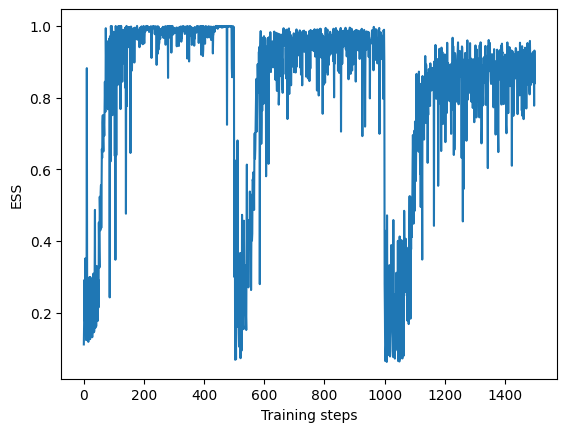

In [18]:
plt.plot(np.asarray(ESS))
plt.ylabel('ESS')
plt.xlabel('Training steps')
plt.show()

-------------
-------------
# Analysis: Reverse Metrics
This sections includes metrics which require samples from the model, e.g., $s\sim q_\theta$ where $q_\theta$ is the autoregressive neural network.
The resulting script `res_paths['sim']` will store:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`

In [21]:
model.eval()
w,E,m,t = model.sample_n_OBS(100,1000)

In [22]:
gamma_analysis(w, res_paths['sim']) 
# Stores data: Loss, FreeEn, ESS_rev
_=gamma_analysis_OBS(E, w, res_paths['sim']) 
# Stores data: Internal Energy
_=gamma_analysis_OBS(np.abs(m), w, res_paths['sim']) 
# Stores data: Absolute magnetization
print(f"Results saved at: {res_paths['sim']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measures.log


-------------
-------------
# Analysis: Forward metrics
> Note to user:
> - This only works for small lattices. As this is just a demo, configurations for larger lattices (or different $\beta$) are not provided and users have to generate reference configurations by themselves. Once configurations are available the pipeline below can be used.
> - Ensure to unzip the configurations before running the code below.


This sections includes metrics which require samples from the true distribution, e.g., $s\sim p$ where $p$ is the target Boltzmann distribution.
Such samples can be obtained with standard methods such as the Cluster method. For the sake of this demo, configs sampled with cluster method are stored in `data/config/Ising_data_nx16_beta0.4400000000_data1000000.dat`.

The script `res_paths['sim_md']` will store:

`Loss_rev, FreeEn_rev, ESS_rev, Loss_fwd, FreeEn_fwd, ESS_fwd, mode_dropping_est,  InternalEn, Absmag`

The script `res_paths['cluster']` will store analysis performed on samples from Cluster method, i.e., $s\sim p$:

`Loss, FreeEn, ESS_rev, InternalEn, Absmag`


In [23]:
ndat = 1000000
path_ising = main_path + f'config/Ising_data_nx{model.Lf}_beta0.4400000000_data{ndat}.dat'

In [24]:
file_exists_or_unzip(path_ising,main_path + f'config')

✅ File '../data/config/Ising_data_nx8_beta0.4400000000_data1000000.dat' found. Continuing...


In [25]:
# Loads data for 16x16
# N.B. This might take some time.
data = np.genfromtxt(path_ising).reshape(-1, Lf, Lf)

In [26]:
cluster_analysis(data, ising_energy, beta, res_paths['cluster']) # U, tau |m|, tau |m|
print(f"Results saved at: {res_paths['cluster']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measuresCluster.log


In [27]:
wf = model.sample_from_MCMC(data, 1000)

In [28]:
gamma_analysis_modedrop(w, wf, res_paths['sim_md']) 
# Stores data: Loss, betaF, ESS, Floss, FbetaF, FESS, modedrop, U, absmag
print(f"Results saved at: {res_paths['sim_md']}")

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measures_modedrop.log


-------------
-------------
# Independent Metropolis-Hastings

The cells below run Neural MCMC using a Metropolis Hastings accept-reject steps to unbias the samples drawn from the model as proposed in [Nicoli et al. Phys. Rev. E (2020)](https://link.aps.org/accepted/10.1103/PhysRevE.101.023304). A cluster analysis is performed on the accepted samples and results are saved in `res_paths['mh']`.

In [29]:
model.eval()

In [30]:
ensemble=make_mcmc_ensemble(model,100, 1000,model.device)

In [31]:
print(f"Acceptance rate: {np.asarray(ensemble['accepted']).mean().item()}")

Acceptance rate: 0.779


In [32]:
cluster_analysis(np.asarray(ensemble['x']).reshape((-1, Lf, Lf) ), model.energy, model.beta, res_paths['mh']) 
# Stores data: U, tau |m|, tau |m|
print(f"Results saved at: {res_paths['mh']}")    

Results saved at: ../data/results/8_0.44_2_3_16_6_32_[5, 3]_measuresIMH.log
